In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
import os
import matplotlib.pyplot as plt
import graphviz
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

print(os.getcwd())


C:\Users\tianh\Dropbox\2017\kaggle\zillow\output


In [2]:
train = pd.read_csv('../input/train_2016_v2.csv')


In [3]:
prop = pd.read_csv('../input/properties_2016.csv')

c:\toolkits\anaconda2-4.2.0\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)

In [5]:
df_train = train.merge(prop, how='left', on='parcelid')


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
transactiondate                 90275 non-null object
airconditioningtypeid           28781 non-null float32
architecturalstyletypeid        261 non-null float32
basementsqft                    43 non-null float32
bathroomcnt                     90275 non-null float32
bedroomcnt                      90275 non-null float32
buildingclasstypeid             16 non-null float32
buildingqualitytypeid           57364 non-null float32
calculatedbathnbr               89093 non-null float32
decktypeid                      658 non-null float32
finishedfloor1squarefeet        6856 non-null float32
calculatedfinishedsquarefeet    89614 non-null float32
finishedsquarefeet12            85596 non-null float32
finishedsquarefeet13            33 non-null float32
finishedsquarefeet15        

In [7]:
x_train = df_train.drop(['parcelid', 
                         'logerror', 
                         'transactiondate', 
                         'propertyzoningdesc', 
                         'propertycountylandusecode'
                         ], axis=1)

train_columns = x_train.columns

y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)


((90275, 55), (90275L,))


In [8]:
for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

In [9]:
#del df_train; gc.collect()
split = int(round(.84*df_train.shape[0],0))

split

75831

In [10]:

x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
x_train = x_train.values.astype(np.float32, copy=False)
x_valid = x_valid.values.astype(np.float32, copy=False)

In [11]:
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)


In [12]:
#stolen tuning from someone elses notebok
params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_leaves'] = 31
params['min_data'] = 400
params['min_data_in_leaf'] = 450
params['min_hessian'] = 1
params['feature_fraction'] = .5

In [13]:
params2 = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 70,
    'learning_rate': 0.0005,
    'min_data': 300,
    'min_hessian': 1,
    'feature_fraction':.6
}

In [14]:
watchlist = [d_valid]


In [15]:
clf = lgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=200)

[1]	valid_0's l1: 0.0649885
Train until valid scores didn't improve in 200 rounds.
[2]	valid_0's l1: 0.0649875
[3]	valid_0's l1: 0.0649868
[4]	valid_0's l1: 0.0649861
[5]	valid_0's l1: 0.0649853
[6]	valid_0's l1: 0.0649838
[7]	valid_0's l1: 0.0649825
[8]	valid_0's l1: 0.0649818
[9]	valid_0's l1: 0.0649806
[10]	valid_0's l1: 0.0649798
[11]	valid_0's l1: 0.0649787
[12]	valid_0's l1: 0.0649777
[13]	valid_0's l1: 0.0649765
[14]	valid_0's l1: 0.0649756
[15]	valid_0's l1: 0.0649745
[16]	valid_0's l1: 0.0649736
[17]	valid_0's l1: 0.0649728
[18]	valid_0's l1: 0.0649717
[19]	valid_0's l1: 0.0649707
[20]	valid_0's l1: 0.0649698
[21]	valid_0's l1: 0.0649686
[22]	valid_0's l1: 0.0649671
[23]	valid_0's l1: 0.0649666
[24]	valid_0's l1: 0.0649657
[25]	valid_0's l1: 0.0649645
[26]	valid_0's l1: 0.0649635
[27]	valid_0's l1: 0.0649625
[28]	valid_0's l1: 0.0649616
[29]	valid_0's l1: 0.0649604
[30]	valid_0's l1: 0.0649593
[31]	valid_0's l1: 0.0649581
[32]	valid_0's l1: 0.0649572
[33]	valid_0's l1: 0.06495

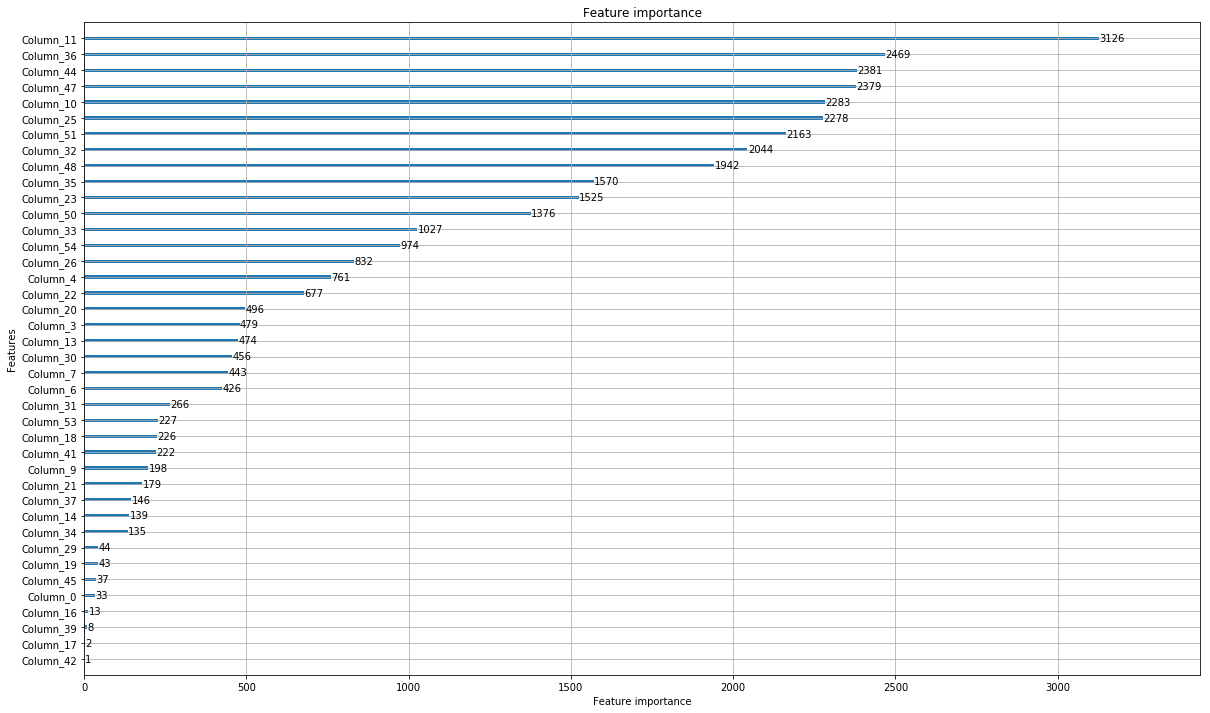

In [79]:
variable_importance = lgb.plot_importance(clf, max_num_features=70, figsize=(20, 12))
plt.show()


In [77]:
train_columns[31]

'propertylandusetypeid'

In [30]:
print(clf.feature_importance)

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x000000002C8169B0>>


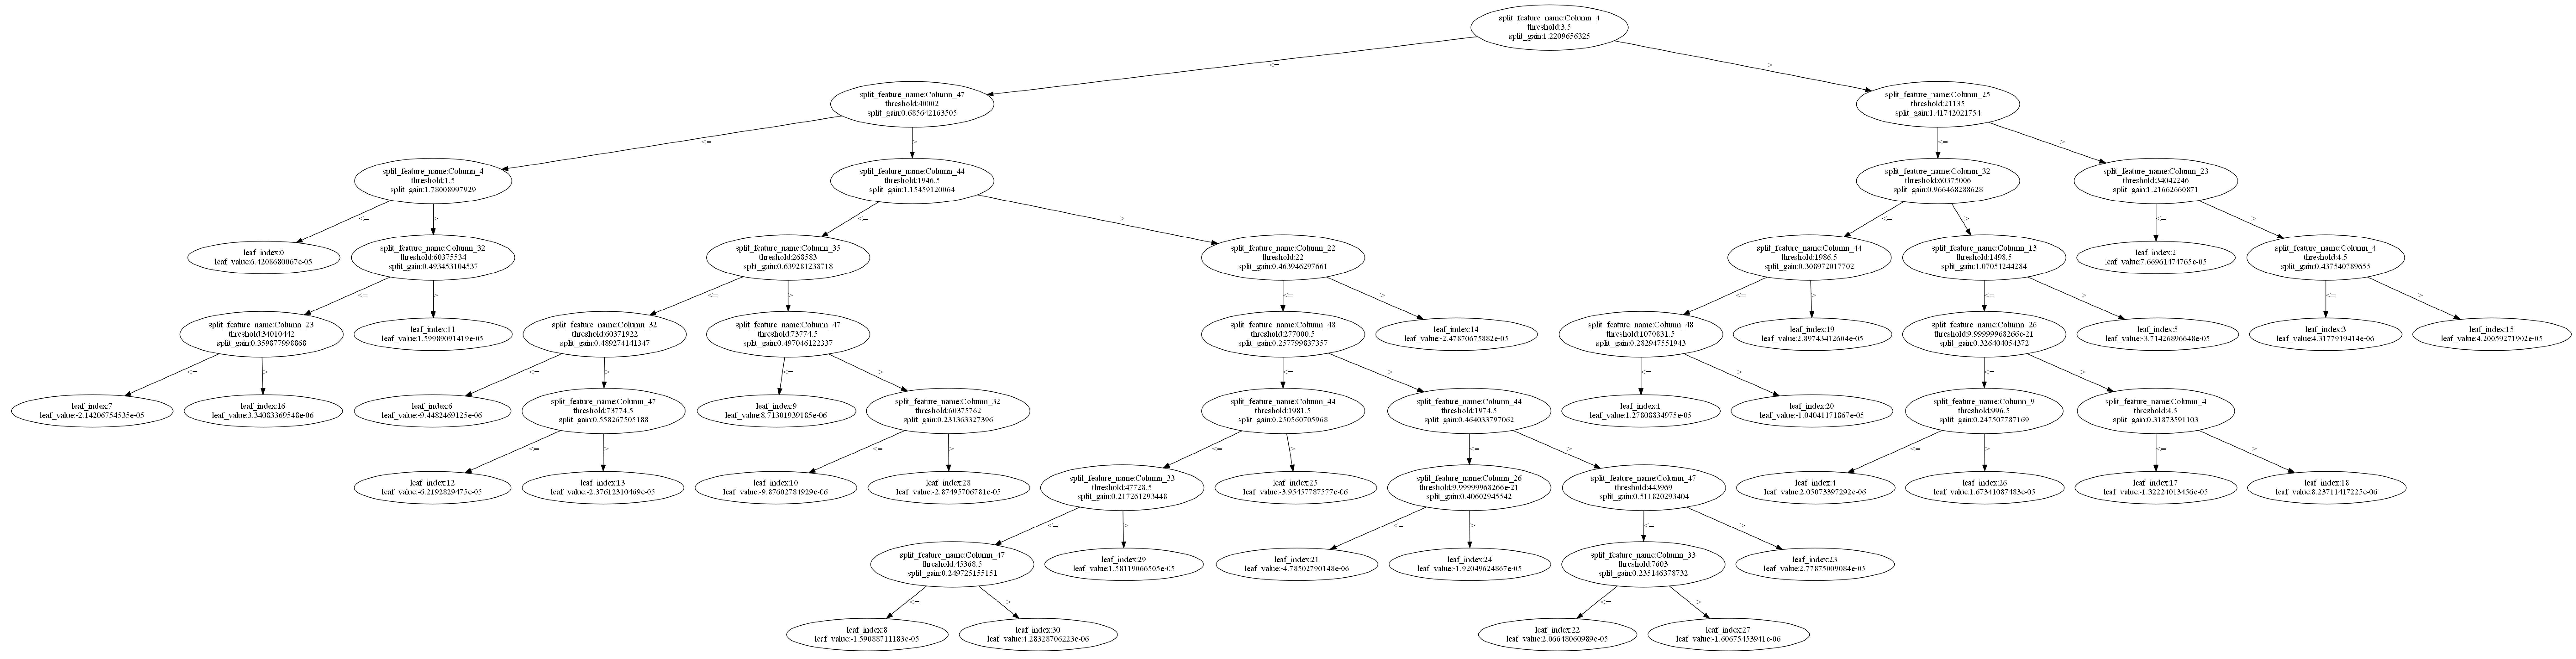

In [27]:
tree_plot = lgb.plot_tree(clf, tree_index=83, figsize=(200, 70), show_info=['split_gain'])
plt.show()


In [ ]:

#print("Prepare for the prediction ...")
#sample = pd.read_csv('../input/sample_submission.csv')
#sample['parcelid'] = sample['ParcelId']
#df_test = sample.merge(prop, on='parcelid', how='left')
#del sample, prop; gc.collect()
#x_test = df_test[train_columns]
#del df_test; gc.collect()


In [ ]:

#print("Start prediction ...")
# num_threads > 1 will predict very slow in kernal
#clf.reset_parameter({"num_threads":1})


In [ ]:
#p_test = clf.predict(x_test)


In [ ]:

#p_test = 0.97*p_test + 0.03*0.011

#del x_test; gc.collect()

#print("Start write result ...")
#sub = pd.read_csv('../input/sample_submission.csv')
#for c in sub.columns[sub.columns != 'ParcelId']:
 #   sub[c] = p_test

#sub.to_csv('lgbm_starter.csv', index=False, float_format='%.4f')